# G only KEGG based network architecture

> 

In [32]:
import numpy as np
import pandas as pd

from EnvDL.core import ensure_dir_path_exists 
from EnvDL.dlfn import g2fc_datawrapper, BigDataset, plDNN_general
from EnvDL.dlfn import ResNet2d, BasicBlock2d
from EnvDL.dlfn import LSUV_

import torch
import torch.nn.functional as F # F.mse_loss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

In [33]:
from tqdm import tqdm
from graphviz import Digraph

In [34]:
# Run settings: 
max_epoch = 2
batch_size = 24

In [35]:
use_gpu_num = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
if use_gpu_num in [0, 1]: 
    torch.cuda.set_device(use_gpu_num)
print(f"Using {device} device")

Using cuda device


In [36]:
cache_path = '../nbs_artifacts/02.31_g2fc_G_ACGT_VNN__scratchpad/'
ensure_dir_path_exists(dir_path = cache_path)

In [37]:
# Settings:
## For graph linear blocks
default_output_size = 50
default_dropout_pr = 0.1
default_block_reps = 1

# ## Training settings
# run_epochs = 15
# epochs_run = 0
# dataloader_batch_size = 1000

## Functions

## Load data

In [38]:
X = g2fc_datawrapper()
X.set_split()
X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 

X.calc_cs('YMat', version = 'np', filter = 'val:train')


Loading and storing default `phno`.


In [39]:
ACGT_gene_slice_list = X.get('KEGG_slices',     ops_string='')


## Generate Graph for DNN

### Functions for Graph Construction

In [40]:
## Building a Neural Net from an arbitrary graph
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})

In [41]:
### Find order that nodes in the graph should be called to have all dependencies run when they are called.
# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
# wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
# another way to do this would have been to 
def find_input_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])

### Process paths into graphs

In [42]:
parsed_kegg_gene_entries = X.get('KEGG_entries')

# Restrict to only those with pathway
kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

# also require to have a non-empty path
kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
     )+'/'+str(len(parsed_kegg_gene_entries)
     )+' Entries'
     )
# kegg_gene_brite[1]['BRITE']['BRITE_PATHS']

Retaining 43.53%, 6067/13939 Entries


### Tiny `n`  gene version of the network:

In [43]:
n_genes = 6067 

print('Using '+str(n_genes)+'/'+str(len(kegg_gene_brite))+' genes.')

# if n_genes is too big, don't visualize.
vis_dot_bool = True
if n_genes > 10:
    vis_dot_bool = False

Using 6067/6067 genes.


In [44]:
# LOD is list of dicts.
# def kegg_brite_LOD_to_connections(
def kegg_connections_build(
        n_genes, 
        kegg_gene_brite):
    """
    The goal here is to have a dict with each node and a list of it's children. 
    For example, the graph
    a--b--d
    |-c--e
    Would be parsed into     
    {'a':['b', 'c'],
    'b':['d'],
    'c':['e']}
    """
    kegg_connections = {}
    # for all genes in list
    for i in tqdm(range(n_genes)): 
        temp = kegg_gene_brite[i]['BRITE']['BRITE_PATHS']
        # clean up to make sure that there are no ":" characters. These can mess up graphviz
        temp = [[temp[j][i].replace(':', '-') for i in range(len(temp[j])) ] for j in range(len(temp))]
        # all paths through graph associated with a gene
        for j in range(len(temp)):
            # steps of the path through the graph
            for k in range(len(temp[j])-1):
                
                # name standardization 
                temp_jk  = temp[j][k]
                temp_jk1 = temp[j][k+1]
                temp_jk  = temp_jk.lower().title().replace(' ', '')
                temp_jk1 = temp_jk1.lower().title().replace(' ', '')
                
                # if this is a new key, add it and add the k+1 entry as it's child
                if temp_jk  not in kegg_connections.keys():
                    kegg_connections[temp_jk] = [temp_jk1]
                else: 
                    # Check to see if there's a new child to add   
                    if temp_jk1 not in kegg_connections[temp_jk]:
                        # make sure that no key contains itself. This was a problem for 'Others' which is now disallowed.
                        if (temp_jk != temp_jk1):
                            # add it.
                            kegg_connections[temp_jk].extend([temp_jk1])
    return(kegg_connections)          

# kegg_brite_LOD_to_connections(
#     n_genes = 6, 
#     kegg_gene_brite = kegg_gene_brite)  

In [45]:
# """
# The goal here is to have a dict with each node and a list of it's children. 
# For example, the graph
# a--b--d
#  |-c--e
# Would be parsed into     
# {'a':['b', 'c'],
#  'b':['d'],
#  'c':['e']}
# """
# kegg_connections = {}

# # for all genes in list
# for i in tqdm(range(n_genes)): 
# # for i in tqdm(range(len(kegg_gene_brite))):    
#     temp = kegg_gene_brite[i]['BRITE']['BRITE_PATHS']
#     # clean up to make sure that there are no ":" characters. These can mess up graphviz
#     temp = [[temp[j][i].replace(':', '-') for i in range(len(temp[j])) ] for j in range(len(temp))]
#     # all paths through graph associated with a gene
#     for j in range(len(temp)):
#         # steps of the path through the graph
#         for k in range(len(temp[j])-1):
            
#             # name standardization 
#             temp_jk  = temp[j][k]
#             temp_jk1 = temp[j][k+1]
#             temp_jk  = temp_jk.lower().title().replace(' ', '')
#             temp_jk1 = temp_jk1.lower().title().replace(' ', '')
            
#             # if this is a new key, add it and add the k+1 entry as it's child
#             if temp_jk  not in kegg_connections.keys():
#                 kegg_connections[temp_jk] = [temp_jk1]
#             else: 
#                 # Check to see if there's a new child to add   
#                 if temp_jk1 not in kegg_connections[temp_jk]:
#                     # make sure that no key contains itself. This was a problem for 'Others' which is now disallowed.
#                     if (temp_jk != temp_jk1):
# #                         if ((temp_jk  != temp_jk1) & (temp_jk1 != 'Others')):
#                         # add it.
#                         kegg_connections[temp_jk].extend([temp_jk1])

# # kegg_connections                        

In [46]:
def kegg_connections_clean(kegg_connections):
    if 'Others' in kegg_connections.keys():
        del kegg_connections['Others']
        print('Removed node "Others"')

    # remove 'Others' as a possible value
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != 'Others']

    # Make sure that no list contains it's own key
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != key]

    # there might be associations with no dependants and with no dependants except those that have no dependants.
    # Build up a list with those keys that don't connect back to snps then I'll pass over the connection dict once to remove references to them.
    rm_list = []
    rm_list_i = len(rm_list)
    rm_list_j = -1
    for i in range(100):
        if rm_list_i == rm_list_j:
            break
        else:
            rm_list = [key for key in kegg_connections.keys() if [e for e in kegg_connections[key] if e not in rm_list]
        ==[]]
            rm_list_j = rm_list_i 
            rm_list_i = len(rm_list)
    # rm_list

    for key in rm_list:
        del kegg_connections[key]
        
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e not in rm_list]
    return kegg_connections

# kegg_connections_clean(kegg_connections = kegg_connections_build(n_genes = 6, kegg_gene_brite = kegg_gene_brite) )

In [47]:
# if 'Others' in kegg_connections.keys():
#     del kegg_connections['Others']
#     print('Removed node "Others"')

# # remove 'Others' as a possible value
# for key in kegg_connections.keys():
#     kegg_connections[key] = [e for e in kegg_connections[key] if e != 'Others']


In [48]:
# # Make sure that no list contains it's own key
# for key in kegg_connections.keys():
#     kegg_connections[key] = [e for e in kegg_connections[key] if e != key]

In [49]:
# # there might be associations with no dependants and with no dependants except those that have no dependants.
# # Build up a list with those keys that don't connect back to snps then I'll pass over the connection dict once to remove references to them.
# rm_list = []
# rm_list_i = len(rm_list)
# rm_list_j = -1
# for i in range(100):
#     if rm_list_i == rm_list_j:
#         break
#     else:
#         rm_list = [key for key in kegg_connections.keys() if [e for e in kegg_connections[key] if e not in rm_list]
#      ==[]]
#         rm_list_j = rm_list_i 
#         rm_list_i = len(rm_list)
# rm_list

In [50]:
# for key in rm_list:
#     del kegg_connections[key]
    
# for key in kegg_connections.keys():
#     kegg_connections[key] = [e for e in kegg_connections[key] if e not in rm_list]

In [51]:
def kegg_connections_append_y_hat(kegg_connections):
    # add yhat node to the graph
    temp_values = []
    for key in kegg_connections.keys():
        temp_values += kegg_connections[key]

    kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]
    return kegg_connections

# kegg_connections_append_y_hat(
#     kegg_connections = kegg_connections_clean(
#         kegg_connections = kegg_connections_build(
#             n_genes = 6, kegg_gene_brite = kegg_gene_brite) ) )

In [52]:
# # add yhat node to the graph
# temp_values = []
# for key in kegg_connections.keys():
#     temp_values += kegg_connections[key]

# kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]

In [53]:
kegg_connections = kegg_connections_append_y_hat(
    kegg_connections = kegg_connections_clean(
        kegg_connections = kegg_connections_build(
            n_genes = 6, kegg_gene_brite = kegg_gene_brite) ) )

100%|██████████| 6/6 [00:00<00:00, 39693.73it/s]


100%|██████████| 46/46 [00:00<00:00, 180822.85it/s]


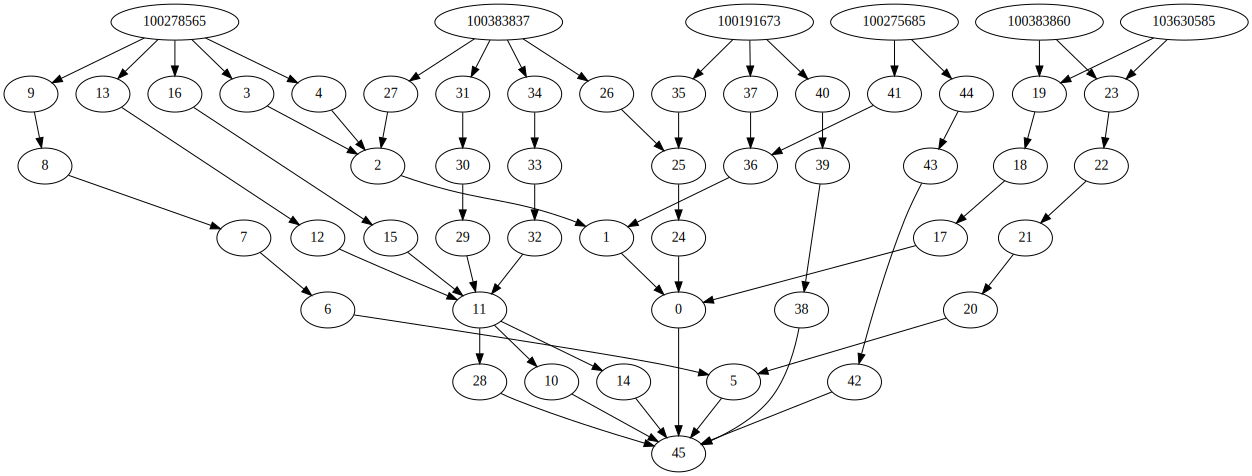

In [54]:
def kegg_connections_digraph(kegg_connections, option = ''):
    dot = ''
    if option == '':
        dot = Digraph()
        for key in tqdm(kegg_connections.keys()):
            dot.node(key)
            for value in kegg_connections[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)

    if option == 'number':
        name_to_num_dict = dict(zip(list(kegg_connections.keys()),
                                    [str(i) for i in range(len(list(kegg_connections.keys())))]))

        temp = {}
        for key in kegg_connections.keys():
            temp[name_to_num_dict[key]] = [name_to_num_dict[e] if e in name_to_num_dict.keys() else e for e in kegg_connections[key]]

        dot = Digraph()
        for key in tqdm(temp.keys()):
            dot.node(key)
            for value in temp[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)                 
                 
    return dot

kegg_connections_digraph(kegg_connections, option = 'number')

In [55]:
# # This is too big to render in full
# dot = ''
# if vis_dot_bool:
#     dot = Digraph()
#     for key in tqdm(kegg_connections.keys()):
#         dot.node(key)
#         for value in kegg_connections[key]:
#             # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
#             dot.edge(value, key)    

# dot

Version with the node names masked for size 

In [56]:
# dot = ''
# if vis_dot_bool:
#     name_to_num_dict = dict(zip(list(kegg_connections.keys()),
#                                 [str(i) for i in range(len(list(kegg_connections.keys())))]))

#     temp = {}
#     for key in kegg_connections.keys():
#         temp[name_to_num_dict[key]] = [name_to_num_dict[e] if e in name_to_num_dict.keys() else e for e in kegg_connections[key]]

#     dot = Digraph()
#     for key in tqdm(temp.keys()):
#         dot.node(key)
#         for value in temp[key]:
#             # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
#             dot.edge(value, key)    

#     # dot.render(directory=cache_path, view=True) 
# dot

### Setup to build the graph

In [57]:
kegg_connections = kegg_connections_append_y_hat(
    kegg_connections = kegg_connections_clean(
        kegg_connections = kegg_connections_build(
            n_genes = 6, kegg_gene_brite = kegg_gene_brite) ) )

len(list(kegg_connections.keys()))

100%|██████████| 6/6 [00:00<00:00, 44073.25it/s]


46

In [58]:
# kegg_connections

def kegg_connections_find_in_out_nodes(kegg_connections):
    # start by finding the top level -- all those keys which are theselves not values
    res = find_uniq_keys_values(input_dict = kegg_connections)
    all_keys = res['all_keys']
    all_values = res['all_values']

    # use the keys to find the input/outputs of the graph
    output_nodes = [e for e in all_keys if e not in all_values]
    input_nodes = [e for e in all_values if e not in all_keys]
    return input_nodes, output_nodes


input_nodes, output_nodes = kegg_connections_find_in_out_nodes(kegg_connections = kegg_connections)

In [59]:
def kegg_connections_find_dependancy_order(kegg_connections, input_nodes):
    # find the dependancies for run order from many dependancies to none
    temp = kegg_connections.copy()

    no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    # first pass. Same as the output nodes identified above
    dependancy_order = []
    # Then iterate
    for ith in range(100): #TODO <- this should be set as a input parameter
        top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
        if top_nodes == []:
            break
        else:
            dependancy_order += top_nodes    
            # remove nodes from the graph that are at the 'top' level and haven't already been removed
            for key in [e for e in dependancy_order if e in temp.keys()]:
                temp.pop(key)

    # dependancy_order
                

    # reverse to get the order that the nodes should be called
    dependancy_order.reverse()
    # dependancy_order



    # Trying out new approach: add a node for the input data tha will only flatten the input.
    dependancy_order = input_nodes+dependancy_order

    for key in input_nodes:
        kegg_connections[key] = [] #[key] # needs to contain itself so the model's `get_input_node()` function works 
                                # or that function needs to change.
    
    return kegg_connections, dependancy_order, no_dependants


kegg_connections, dependancy_order, no_dependants = kegg_connections_find_dependancy_order(kegg_connections= kegg_connections, input_nodes= input_nodes)

In [60]:
def kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite):
    # build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
    brite_node_to_list_idx_dict = {}
    for i in tqdm(range(len(kegg_gene_brite))):
        brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i
    return brite_node_to_list_idx_dict

brite_node_to_list_idx_dict = kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite = kegg_gene_brite)


100%|██████████| 6067/6067 [00:00<00:00, 944679.90it/s]


In [63]:
def build_input_tensor_dict(ACGT_gene_slice_list, no_dependants):    
    input_tensor_dict = {}
    for e in no_dependants:
        input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
    return input_tensor_dict

input_tensor_dict = build_input_tensor_dict(ACGT_gene_slice_list=ACGT_gene_slice_list, no_dependants=no_dependants)

In [64]:
def setup_network_param_dicts(
        kegg_connections,  # for input sizes
        input_tensor_dict, # for input sizes
        dependancy_order,
        default_output_size,
        default_dropout_pr,
        default_block_reps,
    ):
    # Figure out expected input/output shapes
    #==NOTE! This assumes only dense connections!==

    # This could be replaced by a sort of "distance from output" measure
    output_size_dict = dict(zip(dependancy_order, 
                            [default_output_size for i in range(len(dependancy_order))]))
    output_size_dict['y_hat'] = 1 


    # Setup dropout % dictionary
    dropout_pr_dict = dict(zip(dependancy_order, 
                            [default_dropout_pr for i in range(len(dependancy_order))]))
    dropout_pr_dict['y_hat'] = 0 # not required, output node is purely linear without dropout


    # Setup replicates of layers dictionary
    block_rep_dict = dict(zip(dependancy_order, 
                            [default_block_reps for i in range(len(dependancy_order))]))
    block_rep_dict['y_hat'] = 1 # not required, output node is purely linear. Not a linear block

    # output_size_dict
    # dropout_pr_dict
    # block_rep_dict

    # CHANNEL AWARE VERSION -----------------------------------------------------------------------------------
    input_size_dict = kegg_connections.copy()

    # use the expected output sizes from `output_size_dict` to fill in the non-data sizes
    tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
    for e in tqdm(input_size_dict.keys()):
        # overwrite named connections with the output size of those connections
        # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
        
        # is there no channel dim? (major/minor allele)
        if 2 == tensor_ndim:
            input_size_dict[e] = [
                list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]
        elif 3 == tensor_ndim: # There is a channel dim
            input_size_dict[e] = [
                (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]

    # Now walk over entries and overwrite with the sum of the inputs
    for e in tqdm(input_size_dict.keys()):
        input_size_dict[e] = np.sum(input_size_dict[e])

    return input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict

input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict = setup_network_param_dicts(
        kegg_connections = kegg_connections,
        input_tensor_dict = input_tensor_dict,
        dependancy_order = dependancy_order,
        default_output_size = default_output_size,
        default_dropout_pr = default_dropout_pr,
        default_block_reps = default_block_reps,
    )


100%|██████████| 52/52 [00:00<00:00, 207915.93it/s]


100%|██████████| 52/52 [00:00<00:00, 48869.33it/s]


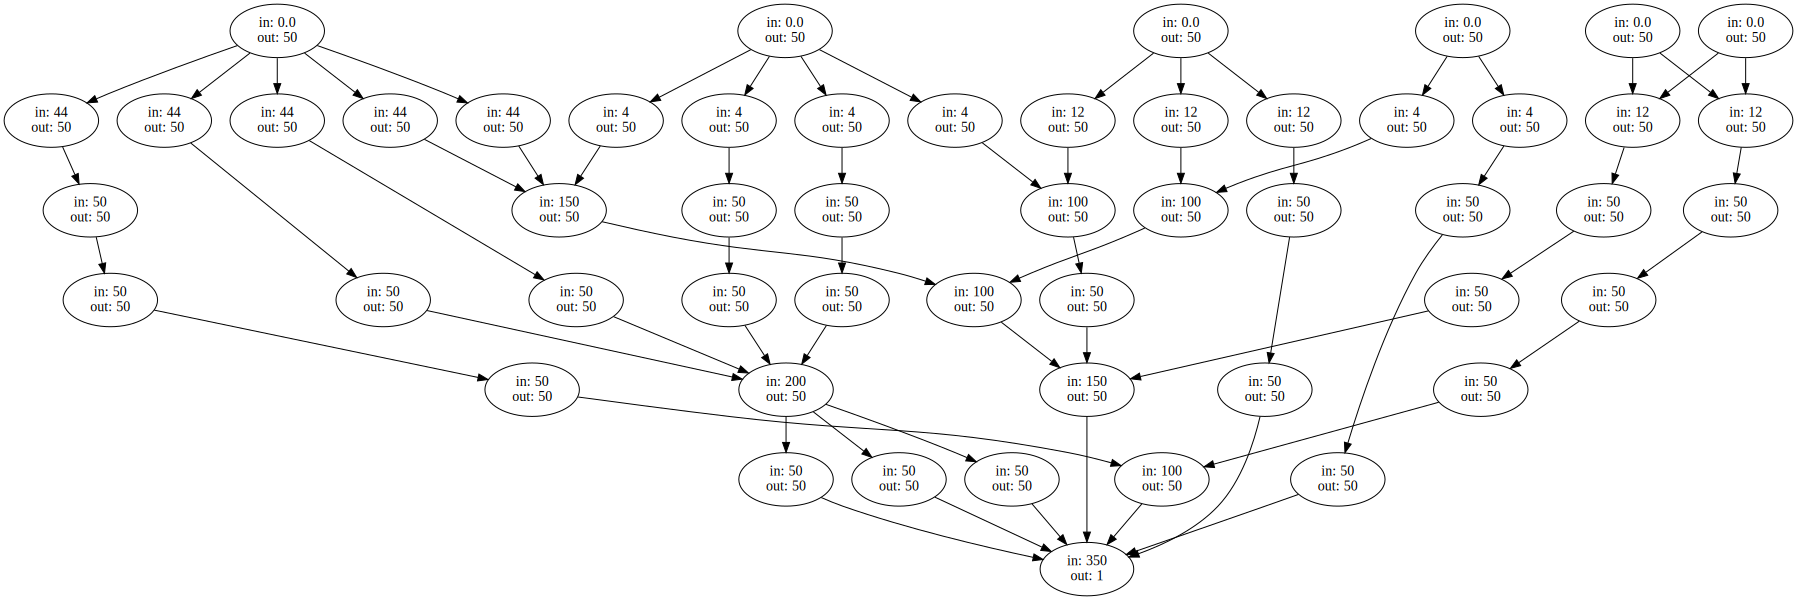

In [65]:
# make in out size graph
dot = ''
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    key_label = 'in: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
    dot.node(key, key_label)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    

dot

In [66]:
# # start by finding the top level -- all those keys which are theselves not values
# res = find_uniq_keys_values(input_dict = kegg_connections)
# all_keys = res['all_keys']
# all_values = res['all_values']

# # use the keys to find the input/outputs of the graph
# output_nodes = [e for e in all_keys if e not in all_values]
# input_nodes = [e for e in all_values if e not in all_keys]

# # (output_nodes, input_nodes)

In [67]:
# # find the dependancies for run order from many dependancies to none
# temp = kegg_connections.copy()

# no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
# # first pass. Same as the output nodes identified above
# dependancy_order = []
# # Then iterate
# for ith in range(100): #TODO <- this should be set as a input parameter
#     top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
#     if top_nodes == []:
#         break
#     else:
#         dependancy_order += top_nodes    
#         # remove nodes from the graph that are at the 'top' level and haven't already been removed
#         for key in [e for e in dependancy_order if e in temp.keys()]:
#              temp.pop(key)

# # dependancy_order

In [68]:
# # reverse to get the order that the nodes should be called
# dependancy_order.reverse()
# # dependancy_order

In [69]:
# # Trying out new approach: add a node for the input data tha will only flatten the input.
# dependancy_order = input_nodes+dependancy_order

# for key in input_nodes:
#     kegg_connections[key] = [] #[key] # needs to contain itself so the model's `get_input_node()` function works 
#                                # or that function needs to change.

In [70]:
# # build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
# brite_node_to_list_idx_dict = {}
# for i in tqdm(range(len(kegg_gene_brite))):
#     brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i

In [71]:
# input_tensor_dict = {}
# for e in no_dependants:
#     input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
# # input_tensor_dict

In [72]:
# # Figure out expected input/output shapes
# #==NOTE! This assumes only dense connections!==

# # This could be replaced by a sort of "distance from output" measure
# output_size_dict = dict(zip(dependancy_order, 
#                         [default_output_size for i in range(len(dependancy_order))]))
# output_size_dict['y_hat'] = 1 
# # output_size_dict

In [73]:
# # Setup dropout % dictionary
# dropout_pr_dict = dict(zip(dependancy_order, 
#                         [default_dropout_pr for i in range(len(dependancy_order))]))
# dropout_pr_dict['y_hat'] = 0 # not required, output node is purely linear without dropout

In [74]:
# # Setup replicates of layers dictionary
# block_rep_dict = dict(zip(dependancy_order, 
#                         [default_block_reps for i in range(len(dependancy_order))]))
# block_rep_dict['y_hat'] = 1 # not required, output node is purely linear. Not a linear block

In [75]:
# # CHANNEL AWARE VERSION -----------------------------------------------------------------------------------
# input_size_dict = kegg_connections.copy()

# # use the expected output sizes from `output_size_dict` to fill in the non-data sizes
# tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
# for e in tqdm(input_size_dict.keys()):
#     # overwrite named connections with the output size of those connections
#     # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
    
#     # is there no channel dim? (major/minor allele)
#     if 2 == tensor_ndim:
#         input_size_dict[e] = [
#             list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
#             if ee in no_dependants
#             else output_size_dict[ee] for ee in input_size_dict[e]]
#     elif 3 == tensor_ndim: # There is a channel dim
#         input_size_dict[e] = [
#             (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
#             if ee in no_dependants
#             else output_size_dict[ee] for ee in input_size_dict[e]]

# # Now walk over entries and overwrite with the sum of the inputs
# for e in tqdm(input_size_dict.keys()):
#     input_size_dict[e] = np.sum(input_size_dict[e])

In [76]:
# model = NeuralNetwork(example_dict = kegg_connections, 
#                       example_dict_input_size = input_size_dict,
#                       example_dict_output_size = output_size_dict,
#                       example_dict_dropout_pr= dropout_pr_dict,
#                       example_block_rep_dict = block_rep_dict,
#                       input_tensor_names = list(input_tensor_dict.keys()),
#                       dependancy_order = dependancy_order) 
# model = model.to(device)
# model(next(iter(training_dataloader))[1])
# model

In [77]:
# dot = ''
# if vis_dot_bool:
#     dot = Digraph()
#     for key in tqdm(kegg_connections.keys()):
#         key_label = 'in: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
#         dot.node(key, key_label)
#         for value in kegg_connections[key]:
#             # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
#             dot.edge(value, key)    

# dot

## Set up DataSet

Now we have

- A dictionary with the connections: `example_dict`
- The expected input sizes for each node: `example_dict_input_size`
- A dictionary with the input tensors: `input_tensor_dict`
- A list of the input tensors' names: `no_dependants` 
- A list with the order that each module should be called: `dependancy_order`

To have a fair test of whether the model is working, I want to ensure there is information to learn in the dataset. To this end I'm using just two genotypes.

In [78]:
x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]

In [79]:
# YMat_cs = calc_cs(YMat[train_idx])
# y_cs = apply_cs(YMat, YMat_cs)

In [80]:
# y_temp = torch.from_numpy(y_cs).to(torch.float)#[:, None]

In [81]:
x_list_temp[0].shape

torch.Size([4926, 4, 1])

## Set up NeuralNetwork, Data Loader

In [82]:
# Working version ====
# Doesn't pass output node through relu
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 example_dict_dropout_pr,
                 example_block_rep_dict,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr, block_reps):
            block_list = []
            for i in range(block_reps):
                if i == 0:
                    block_list += [
                        nn.Linear(in_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
                else:
                    block_list += [
                        nn.Linear(out_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
        
            block = nn.ModuleList(block_list)
            return(block)           
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=example_dict_dropout_pr[key],
                                 block_reps=example_block_rep_dict[key])
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                

        self.nn_layer_list = nn.ModuleList(layer_list)

        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
#             print(input_node, self.result_list_lookup)
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
            
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    x[self.input_tensor_lookup[key]]
                ).clone()]

            elif key != 'y_hat':
                # refactored to handle module lists (even if module list contains only one entry)
                out = torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)
            
                for module in self.nn_layer_list[nn_layer_list_idx]:
                    out = module(out)
        
                self.result_list = self.result_list + [out] 
            
            else:
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]            

        return self.result_list[self.result_list_lookup['y_hat']]

In [83]:
# model = NeuralNetwork(example_dict = kegg_connections, 
#                       example_dict_input_size = input_size_dict,
#                       example_dict_output_size = output_size_dict,
#                       example_dict_dropout_pr= dropout_pr_dict,
#                       example_block_rep_dict = block_rep_dict,
#                       input_tensor_names = list(input_tensor_dict.keys()),
#                       dependancy_order = dependancy_order) 
# model = model.to(device)
# model(next(iter(training_dataloader))[1])
# model

In [84]:
class ListDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 x_list,
                 obs_idxs, # this is a list of the indexes used. It allows us to pass in smaller 
                           # tensors and then get the right genotype
                 obs_geno_lookup,
                 transform = None, target_transform = None,
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list
        self.obs_idxs = obs_idxs
        self.obs_geno_lookup = obs_geno_lookup
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        
        new_idx = self.obs_idxs[idx]
        idx_geno = self.obs_geno_lookup[new_idx, 1]
        x_idx =[x[idx_geno, ] for x in self.x_list] 
        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx

In [85]:
training_dataloader = DataLoader(ListDataset(
        y =               X.get('YMat',ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
        x_list = [e.to('cuda') for e in x_list_temp],
        obs_idxs =        X.get('val:train',       ops_string='   asarray from_numpy      '), 
        obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
    ),
    batch_size = batch_size,
    shuffle = True
)


validation_dataloader = DataLoader(ListDataset(
        y =               X.get('YMat',ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
        x_list = [e.to('cuda') for e in x_list_temp],
        obs_idxs =        X.get('val:test',       ops_string='   asarray from_numpy      '), 
        obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
    ),
    batch_size = batch_size,
    shuffle = True
)
# next(iter(training_dataloader))

In [86]:
# training_dataloader = DataLoader(ListDataset(
#         y = y_temp[train_idx][:, None].to('cuda'),
#         x_list = [e.to('cuda') for e in x_list_temp],
#         obs_idxs = train_idx, 
#         obs_geno_lookup = obs_geno_lookup
#     ),
#     batch_size = dataloader_batch_size,
#     shuffle = True
# )

# validation_dataloader = DataLoader(ListDataset(
#         y = y_temp[test_idx][:, None].to('cuda'),
#         x_list = [e.to('cuda') for e in x_list_temp],
#         obs_idxs = test_idx, 
#         obs_geno_lookup = obs_geno_lookup
#     ),
#     batch_size = dataloader_batch_size,
#     shuffle = True
# )

# # next(iter(training_dataloader))[1]

In [87]:
# next(iter(training_dataloader))[1].shape

In [88]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      example_dict_dropout_pr= dropout_pr_dict,
                      example_block_rep_dict = block_rep_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order)


model.to('cuda')
# LSUV_(model, data = next(iter(training_dataloader))[1])
# model(next(iter(training_dataloader))[1])

NeuralNetwork(
  (nn_layer_list): ModuleList(
    (0-5): 6 x Flatten(start_dim=1, end_dim=-1)
    (6-7): 2 x ModuleList(
      (0): Linear(in_features=4, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (8): ModuleList(
      (0): Linear(in_features=12, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (9): ModuleList(
      (0): Linear(in_features=44, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (10): ModuleList(
      (0): Linear(in_features=4, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (11-12): 2 x ModuleList(
      (0): Linear(in_features=12, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (13-14): 2 x ModuleList(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
   

In [89]:
LSUV_(model, data = next(iter(training_dataloader))[1])
# model(next(iter(training_dataloader))[1])

Applying orthogonal init (zero init if dim < 2) to params in 46 module(s).
Applying LSUV to 46 module(s) (up to 10 iters per module):
Module  0 after  2 itr(s) | Mean:  0.107 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  1 after  2 itr(s) | Mean:  0.096 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  2 after  2 itr(s) | Mean: -0.039 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  3 after  2 itr(s) | Mean:  0.192 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  4 after  2 itr(s) | Mean: -0.002 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  5 after  2 itr(s) | Mean: -0.108 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  6 after  2 itr(s) | Mean: -0.001 | Std: 1.000 | <class 'torch.nn.modules.linear.Linear'>
Module  7 after  2 itr(s) | Mean:  0.133 | Std: 0.989 | <class 'torch.nn.modules.linear.Linear'>
Module  8 after  2 itr(s) | Mean: -0.023 | Std: 1.008 | <class 'torch.nn.modules.linear.Li

In [90]:
class plVNN(pl.LightningModule):
    def __init__(self, mod):
        super().__init__()
        self.mod = mod
    def training_step(self, batch, batch_idx):
        y_i, xs_i = batch
#         pred, out = self.mod(xs_i)
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log("train_loss", loss)
        
#         with torch.no_grad():
#             weight_list=[(name, param) for name, param in model.named_parameters() if name.split('.')[-1] == 'weight']
#             for l in weight_list:
#                 self.log(("train_mean"+l[0]), l[1].mean())
#                 self.log(("train_std"+l[0]), l[1].std())        
        return(loss)
        
    def validation_step(self, batch, batch_idx):
        y_i, xs_i = batch
#         pred, out = self.mod(xs_i)
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log('val_loss', loss)        
     
    def configure_optimizers(self, **kwargs):
        optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        return optimizer    

In [91]:

# 2 epochs took 58 minutes so a 3 day weekend would be 
# 24*3*2=144 epochs
# max_epoch = 150

In [92]:
VNN = plVNN(model)
optimizer = VNN.configure_optimizers()

logger = TensorBoardLogger("tb_logs", name="vnn-02.31-TESTING-REMOVE-ME")
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger)

trainer.fit(model=VNN, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

/home/kickd/miniconda3/envs/fastai/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kickd/miniconda3/envs/fastai/lib/python3.11/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | mod  | Neur

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kickd/miniconda3/envs/fastai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/kickd/miniconda3/envs/fastai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/kickd/miniconda3/envs/fastai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# torch.save(VNN.mod, cache_path+'vnn'+'.pt')

In [ ]:
# torch.save(VNN, cache_path+'vnn'+'.pt')